<a href="https://colab.research.google.com/github/scotthwa97/NMA/blob/main/projects/behavior_and_theory/motor_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor RNNs

contact: steeve.laquitaine@epfl.ch

Heavily inspired from [Feulner & Clopath, 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008621)

## Setup

In [17]:
# import python packages
import os
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from IPython import display

In [18]:
# @title Set the project path
proj_path = "proj_rnn/"
if not os.path.exists(proj_path):
  os.makedirs(proj_path)

# set the directories where the results will be saved
savedir = os.path.join(proj_path, 'data/fig2/')
if not os.path.exists(savedir):
  os.makedirs(savedir)

## Utils

### Network

In [19]:
# @title RNN encoder
class RNN(object):
    """
    Class implementing a recurrent network (not following Dale's law).

    Parameters:
    -----------
    * N: number of neurons
    * N_in: how many inputs can the network have
    * N_out: how many neurons are recorded by external device
    * g: recurrent coupling strength
    * p: connection probability
    * tau: neuron time constant
    * dt: set dt for simulation
    * delta: defines initial learning rate for FORCE
    * P_plastic: how many neurons are plastic in the recurrent network
    """
    def __init__(self, N=800, g=1.5, p=0.1, tau=0.1, dt=0.01,
                 N_in=6, use_bias_learning = True):
        # set parameters
        self.N = N
        self.g = g
        self.p = p
        self.K = int(p*N)
        self.tau = tau
        self.dt = dt
        self.b = np.zeros(self.N) # adds the biases
        self.lr = 1e-3
        self.use_bias_learning = use_bias_learning

        # create recurrent W
        mask = np.random.rand(self.N,self.N)<self.p
        np.fill_diagonal(mask,np.zeros(self.N))
        self.mask = mask
        self.W = self.g / np.sqrt(self.K) * np.random.randn(self.N,self.N) * mask

        # create Win and Wout
        self._N_in = N_in
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    @property
    def N_in(self):
        return self._N_in

    @N_in.setter
    def N_in(self, value):
        self._N_in = value
        self.W_in = (np.random.rand(self.N, self._N_in)-0.5)*2.

    def save(self,filename):
        np.savez(
            filename,
            N = self.N,
            K = self.K,
            tau = self.tau,
            g = self.g,
            p = self.p,
            dt = self.dt,
            W_in = self.W_in,
            W = self.W,
            N_in = self._N_in,
        )

    def load(self,filename):
        net = np.load(filename+'.npz')
        self.N = int(net['N'])
        self.dt = float(net['dt'])
        self.K = int(net['K'])
        self.tau = float(net['tau'])
        self.g = float(net['g'])
        self.p = float(net['p'])
        self.W_in = net['W_in']
        self.W = net['W']
        self._N_in = int(net['N_in'])

    def update_activation(self):
        self.z = np.tanh(self.r)

    def update_neurons(self,ext):
        self.r = self.r + self.dt/self.tau * \
             (-self.r + np.dot(self.W, self.z) + np.dot(self.W_in,ext)) + self.b

        self.update_activation()

    def simulate(self, T, ext=None, r0=None):

        # define time
        time = np.arange(0,T,self.dt)
        tsteps = int(T/self.dt)

        # create input in case no input is given
        if ext is None:
            ext = np.zeros((tsteps,self.N_in))

        # check if input has the right shape
        if ext.shape[0]!=tsteps or ext.shape[1]!=self.N_in:
            print('ERROR: stimulus shape should be (time x number of input nodes)')
            return

        # set initial condition
        if r0 is None:
            self.r = (np.random.rand(self.N)-0.5)*2.
        else:
            self.r = r0
        self.update_activation()

        # start simulation
        record_r = np.zeros((tsteps,self.N))
        record_r[0,:] = self.r
        for i in range(1,tsteps):
            self.update_neurons(ext=ext[i])
            # store activity
            record_r[i,:] = self.r
        return time, record_r, np.tanh(record_r)

    def relearn(self, trials, ext, ntstart, decoder, feedback, target, delta=1.,
                wplastic=None):
        """
        Args
          self.z: RNN network's activation
          ext (np.array): stimuli (n_targets, n timesteps, n_targets)
          decoder (np.array): (N units, 2d coordinates) decoder weights
          feedback (np.array): (N units, 2d coordinates) feedback weights
          target: (n_targets, N timesteps, 2d coordinates) target coordinates

        Returns:

          loss (np.array): loss by trial
        """
        # get number of timesteps within trial
        tsteps = ext.shape[1]

        # set up learning
        if wplastic is None:
            self.W_plastic = [np.where(self.W[i,:]!=0)[0] for i in range(self.N)]
        else:
            self.W_plastic = wplastic
        self.P = [1./delta*np.eye(len(self.W_plastic[i])) for i in range(len(self.W_plastic))]

        # create n trials of target indices chosen from 0 to 5
        order = np.random.choice(range(ext.shape[0]), trials, replace=True)

        # initialize calculated loss per trial
        record_loss = np.zeros(trials)

        # loop over trials
        for t in range(trials):

            # initialize loss
            loss = 0.
            self.r = (np.random.rand(self.N)-0.5)*2.
            self.update_activation()

            # loop over time
            for i in range(1,tsteps):

                # update units
                self.update_neurons(ext=ext[order[t],i])

                # learn
                if i > ntstart and i%2==0:

                    # decode network's predicted
                    # target coordinates
                    c = decoder @ self.z

                    # calculate prediction error between
                    # decoded and true target coordinates (2,)
                    errc = c - target[order[t], i]

                    # calculate the error update assigned to each weight
                    err1 = feedback @ errc

                    # updating biases

                    # calculate loss
                    loss += np.mean(err1**2)

                    # update plastic recurrent weights
                    for j in range(self.N):
                        z_plastic = self.z[self.W_plastic[j]]
                        pz = np.dot(self.P[j], z_plastic)
                        norm = (1. + np.dot(z_plastic.T,  pz))
                        if self.use_bias_learning:
                            self.b[j] -= self.lr * err1[j]
                        self.P[j] -= np.outer(pz, pz)/norm
                        # self.b[j] -= self.lr * err1[j]

                        # use error-transformed feedbacks to update
                        # plastic weights
                        self.W[j, self.W_plastic[j]] -= err1[j] * pz / norm


            # tape loss
            record_loss[t] = loss
            print('Loss in Trial %d is %.5f'%(t+1,loss))
        return record_loss

    def calculate_manifold(self, trials, ext, ntstart):
        tsteps = ext.shape[1]
        T = self.dt*tsteps
        points = (tsteps-ntstart)
        activity = np.zeros((points*trials,self.N))
        order = np.random.choice(range(ext.shape[0]),trials,replace=True)
        for t in range(trials):
            time, r, z = self.simulate(T,ext[order[t]])
            activity[t*points:(t+1)*points,:] = z[ntstart:,:]
        cov = np.cov(activity.T)
        ev,evec = np.linalg.eig(cov)
        pr = np.round(np.sum(ev.real)**2/np.sum(ev.real**2)).astype(int)
        xi = activity @ evec.real
        return activity,cov,ev.real,evec.real,pr,xi,order

def save_RNN(network, savedir:str):
  """write RNN object and weights in savedir
  """
  network.save(savedir+'network')
  np.save(savedir+'W_initial', network.W)

def save_RNN_sinewave(network, savedir:str):
  """write RNN sinewave object and weights in savedir
  """
  network.save(savedir + 'network_sinewave')
  np.save(savedir + 'W_initial_sinewave', network.W)

In [20]:
# @title BCI decoders
def train_reaching_decoder(inputP, target, order, n_output_units:int=2):
    """train the decoder to perform the six-cue
    motor reaching task
    """
    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output_units))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X,Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

def create_reaching_task_decoder(reaching_network, n_output_units:int=2):
  """create feedforward decoder from RNN to (x,y) output units
  for learning (random weights)"""

  # set parameters
  SCALE = 0.04
  DENOM = 0.2

  # create random weights
  reaching_decoder = np.random.randn(n_output_units, reaching_network.N)
  initial_decoder_fac = SCALE * (target_max / DENOM)

  # normalize decoder matrix
  reaching_decoder *= (initial_decoder_fac / np.linalg.norm(reaching_decoder))
  return reaching_decoder

def train_force_exertion_decoder(inputP, target, order, n_output:int=1):
    """train the decoder to perform the force exertion
    motor task. The network must apply force at
    oscillating amplitude (following a sinewave function
    of time)
    """

    # initialize predictor neural activity
    X = np.zeros((inputP.shape[0]*inputP.shape[1], inputP.shape[-1]))

    # initialize predicted target
    Y = np.zeros((inputP.shape[0]*inputP.shape[1], n_output))

    # fill up
    for j in range(inputP.shape[0]):
        X[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = inputP[j]
        Y[j*inputP.shape[1]:(j+1)*inputP.shape[1],:] = target[order[j]]

    # regress target against neural activity
    reg = lm.LinearRegression()
    reg.fit(X, Y)

    # make predictions
    y = reg.predict(X)
    mse = np.mean((y-Y)**2)
    return reg.coef_, mse

In [21]:
# @title Feedback weights
def get_feedback_weights(decoder):
  """calculate feedback weights from (x,y) output units back to RNN
  as the matrix inverse of the feedforward decoder weights from the RNN to
  the output units"""
  return np.linalg.pinv(decoder)

In [22]:
# @title Loss function
def get_cost(result, target, order):
  cost = 0
  for j in range(result.shape[0]):
    error = result[j, :, :] - target[order[j], :, :]
    cost += np.mean(error**2)
  return cost

In [23]:
# @title Get the manifold
def get_manifold(network):

  # calculate the manifold
  activity, cov, ev, evec, pr, xi, order = network.calculate_manifold(trials=manifold_trials, ext=stimulus, ntstart=pulse_length)

  # reshape the activity
  activity_reshaped = activity.reshape(manifold_trials, -1, network.N)
  xi2 = xi.reshape(manifold_trials, -1, network.N)
  return {"xi2":xi2, "order":order, "xi":xi, "cov":cov, "ev":ev, "evec":evec, "pr":pr,"activity":activity, "activity_reshaped":activity_reshaped}

def save_reaching_manifold(data, T):
  dic = {'manifold': {'original': data['manifold']}, 'perturbations': {'transformed':T}}
  np.save(savedir + 'reaching_relearning_results', dic)

def transform_reaching(reaching_network, manifold_out, W_bci4, n_output_units:int=2):

  P = manifold_out["evec"].real.T
  D = np.zeros((2, reaching_network.N))
  D[:,:reduced_dim] = W_bci4
  transformed = D @ P
  result = manifold_out["activity_reshaped"] @ transformed.T
  cost = get_cost(result, target[:,pulse_length:,:], manifold_out["order"])
  return transformed

In [24]:
# @title simulation
def simulate_reaching(savdir, dt):

  # set plot parameters
  COL_ORIG = 'k'
  ALPHA = 1

  # load velocity data
  data = np.load(savdir + 'reaching_relearning_results.npy', allow_pickle=True).item()
  activity = data['manifold']['original']['activity2']
  o_original = activity @ data['perturbations']['transformed'].T

  # reconstruct trajectories from velocities
  pos_original = np.zeros(o_original.shape)
  for j in range(activity.shape[1]):
      pos_original[:,j,:] = pos_original[:,j-1,:] + o_original[:,j,:]*dt

  # plot trajectories
  plt.figure(figsize=(15,10), dpi=96)
  plt.subplot(2,3,3)
  for j in range(manifold_trials):
      plt.plot(pos_original[j,:,0], pos_original[j,:,1], COL_ORIG, alpha=ALPHA);
  plt.title('simulated reaching');
  plt.xlabel('x-position on screen');
  plt.ylabel('y-position on screen');

### Task

In [25]:
# @title "reaching" task
def create_reaching_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=6, amplitude:float=1., twod:bool=False):
    """create the set of stimuli, which we sample from at each trial

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float):
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimulus
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    if twod:
        phis = np.linspace(0,2*np.pi,targets,endpoint=False)
        for j in range(stimulus.shape[0]):
            stimulus[j,:pulse_length,0] = amplitude*np.cos(phis[j])
            stimulus[j,:pulse_length,1] = amplitude*np.sin(phis[j])
            stimulus[j,:pulse_length,2:] = 0
    else:
        for j in range(n_targets):
            stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def create_reaching_task_targets(tsteps, pulse_steps, n_targets:int=6, stype='constant', target_max:float=0.2):
    """create the set of target coordinates (6 by default) that the network
    must reach before the end of a trial. The network starts from the center of
    the computer screen (coordinate: (0,0))
    """
    # create target trajectories
    phis = np.linspace(0, 2*np.pi, n_targets, endpoint=False)
    rs = np.zeros(tsteps)

    # define each target's x and y coordinate
    rs[pulse_steps:] = np.ones(tsteps-pulse_steps)*target_max
    traj = np.zeros((n_targets,tsteps,2))
    for j in range(n_targets):

        # create x-coordinate on screen
        traj[j,:,0] = rs*np.cos(phis[j])

        # create y-coordinate on screen
        traj[j,:,1] = rs*np.sin(phis[j])
    return traj

def plot_reaching_task_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets,1)

  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))

  for target in stimulus_set:
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)

  axes[-1].set_xlabel("time within a trial (secs)")

  fig.tight_layout()

  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def plot_reaching_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6))
  for target_i in tuple(range(n_targets)):
    axes[target_i].plot(target[target_i,:,:])

    # legend
    axes[target_i].set_xticks([0, tsteps])
    axes[target_i].set_xticklabels([0, T])
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9)
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01])

  axes[-1].set_xlabel("time within a trial (secs)")
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False)
  fig.tight_layout()

In [26]:
# @title "force" task
def create_force_task_stimuli(tsteps:int, pulse_steps:int, n_targets:int=1, amplitude:float=1., twod:bool=False):
    """create a stimulus set

    Args:
      tsteps (int):
      pulse_steps (int):
      n_targets (int):
      amplitude (float)
      twod (bool):

    Returns:
      (np.array): array of (n_targets, pulse_steps, n_targets) stimuli
    """

    # create stimuli
    stimulus = np.zeros((n_targets, tsteps, n_targets))
    for j in range(n_targets):
        stimulus[j,:pulse_steps,j] = amplitude
    return stimulus

def plot_force_stimuli(stimulus, n_targets:int, tsteps:int, T:int):

  # plot target cue with "pulse_steps" duration
  # at the beginning of each trial
  stimulus_set = np.arange(0, n_targets, 1)
  fig, axes = plt.subplots(n_targets, 1, figsize=(30,9))
  for target in stimulus_set:

    # plot
    axes[target].imshow(stimulus[target,:,:].T, aspect=10, cmap="binary");

    # legend
    axes[target].set_yticks(stimulus_set)
    axes[target].set_yticklabels(stimulus_set, fontsize=9)
    axes[target].set_xticks([0, tsteps])
    axes[target].set_xticklabels([0, T])
    axes[target].set_ylabel("possible targets", fontsize=9)
  axes[-1].set_xlabel("time within a trial (secs)")
  fig.tight_layout()
  print("stimuli:")
  print(f"-a set of {stimulus.shape[0]} possible trial stimuli (panels)")
  print(f"-{stimulus.shape[1]} timesteps within a trial stimulus")
  print(f"-{stimulus.shape[2]} possible cued target in a trial stimulus")

def create_force_task_targets(tsteps, pulse_steps, targets:list=[1, 10], target_max:float=0.2):
  """exert force with an oscillatorily increasing and decreasing amplitude
  """
  n_targets = len(targets)
  rs = np.zeros(tsteps)
  traj = np.zeros((n_targets, tsteps, 1))
  rs[pulse_steps:] = np.ones(tsteps - pulse_steps) * target_max
  x_coord = np.linspace(-2*np.pi, 2*np.pi, tsteps, endpoint=False)
  freq = []
  for ix in range(n_targets):
    traj[ix,:,0] = rs * np.sin(targets[ix] * x_coord)
  return traj

def plot_force_task_targets(target, tsteps:int, T:int):

  # count targets
  n_targets = target.shape[0]

  # plot target coordinates throughout trial
  fig, axes = plt.subplots(n_targets,1, figsize=(6,6));
  for target_i in tuple(range(n_targets)):

    # plot
    axes[target_i].plot(target[target_i,:,:]);

    # legend
    axes[target_i].set_xticks([0, tsteps]);
    axes[target_i].set_xticklabels([0, T]);
    axes[target_i].set_ylabel("target" "\n" "coord (a.u.)", fontsize=9);
    axes[target_i].set_ylim([target.min()-0.01, target.max()+0.01]);
  axes[-1].set_xlabel("time within a trial (secs)");
  plt.legend(["x-coord", "y-coord"], fontsize=9, frameon=False);
  fig.tight_layout();

## Create task 1: "reaching"

In [27]:
# @title set parameters
# TODO: create dictionary

seed_id = 2                 # random seed for this simulation
np.random.seed(seed_id)

# time parameters
dt = 0.01                   # time discretization (secs, see paper table 1)
T = 2                       # trial duration (secs, see paper table 1)
time = np.arange(0, T, dt)
tsteps = len(time)          # number of time steps within a trial
pulse_length = int(0.2/dt)  # pulse length in number of timesteps

# network parameters
N = 800                     # RNN number of units
g = 1.5                     # RNN recurrent connection strengths (a.u)
p = 0.1                     # RNN connection probability
tau = 0.1                   # unit time constant tau (secs)
N_OUTPUT_UNITS = 2          # number of output units (2 for x and y)

# task parameters
targets = 6                 # number of reaching targets
stimulus_type = 'constant'  # constant, linear, normal
target_max = 0.2            # 0.2 or 0.01
n_learning1_trials = 80       # initial network learning
delta = 20.
relearning_trials = 80      # relearning
deltarec = 20.

# analyses parameters
manifold_trials = 50        # manifold calculation
reduced_dim = 10

stimuli:
-a set of 6 possible trial stimuli (panels)
-200 timesteps within a trial stimulus
-6 possible cued target in a trial stimulus


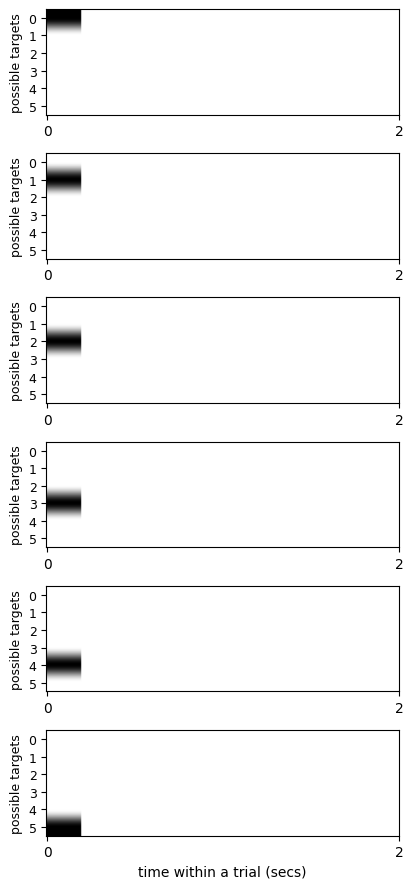

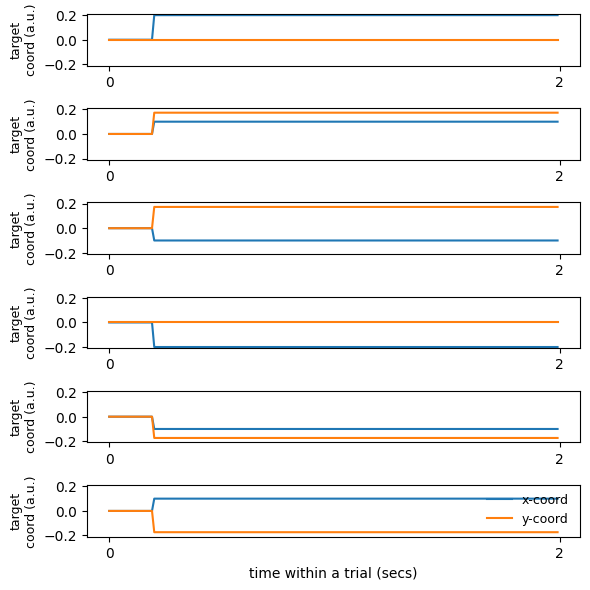

In [28]:
# @title Create stimuli and targets

# create stimuli and plot
stimulus = create_reaching_task_stimuli(tsteps, pulse_length, twod=False)
plot_reaching_task_stimuli(stimulus, targets, tsteps, T)

# create target (targets x timesteps x 2D coordinates) and plot
target = create_reaching_task_targets(
    tsteps,
    pulse_length,
    n_targets=targets,
    stype=stimulus_type,
    target_max=target_max
    )
plot_reaching_task_targets(target, tsteps, T)

In [ ]:
# @title build and train the network
# With bias learning
reaching_network_bias = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets, use_bias_learning=True)
save_RNN(reaching_network_bias, savedir)

reaching_decoder_bias = create_reaching_task_decoder(reaching_network_bias, n_output_units=N_OUTPUT_UNITS)
reaching_feedback_bias = get_feedback_weights(reaching_decoder_bias)

reaching_loss_bias = reaching_network_bias.relearn(n_learning1_trials, stimulus,
                                                   pulse_length, reaching_decoder_bias,
                                                   reaching_feedback_bias, target, delta=delta)

# Save results
np.save(f'{savedir}W_stabilized_reaching_bias', reaching_network_bias.W)

# Without bias learning
reaching_network_nobias = RNN(N=N, g=g, p=p, tau=tau, dt=dt, N_in=targets, use_bias_learning=False)
save_RNN(reaching_network_nobias, savedir)

reaching_decoder_nobias = create_reaching_task_decoder(reaching_network_nobias, n_output_units=N_OUTPUT_UNITS)
reaching_feedback_nobias = get_feedback_weights(reaching_decoder_nobias)

reaching_loss_nobias = reaching_network_nobias.relearn(n_learning1_trials, stimulus,
                                                       pulse_length, reaching_decoder_nobias,
                                                       reaching_feedback_nobias, target, delta=delta)

np.save(f'{savedir}W_stabilized_reaching_nobias', reaching_network_nobias.W)


Loss in Trial 1 is 0.34350
Loss in Trial 2 is 0.54829
Loss in Trial 3 is 0.05808
Loss in Trial 4 is 0.46003
Loss in Trial 5 is 0.34971
Loss in Trial 6 is 0.50510
Loss in Trial 7 is 0.09826
Loss in Trial 8 is 0.23488
Loss in Trial 9 is 0.06327
Loss in Trial 10 is 0.30020
Loss in Trial 11 is 0.95538
Loss in Trial 12 is 0.13835
Loss in Trial 13 is 0.21980
Loss in Trial 14 is 0.24981
Loss in Trial 15 is 0.29226
Loss in Trial 16 is 0.12715
Loss in Trial 17 is 0.33632
Loss in Trial 18 is 0.11543
Loss in Trial 19 is 0.25913
Loss in Trial 20 is 0.14523
Loss in Trial 21 is 0.13445
Loss in Trial 22 is 0.06734
Loss in Trial 23 is 0.10314
Loss in Trial 24 is 0.08077
Loss in Trial 25 is 0.16842
Loss in Trial 26 is 0.22506
Loss in Trial 27 is 0.16354
Loss in Trial 28 is 0.06757
Loss in Trial 29 is 0.18950
Loss in Trial 30 is 0.11345
Loss in Trial 31 is 0.08617
Loss in Trial 32 is 0.05168
Loss in Trial 33 is 0.07601
Loss in Trial 34 is 0.21082
Loss in Trial 35 is 0.04768
Loss in Trial 36 is 0.14203
L

In [ ]:
# Compare Learning Curves (Loss)
plt.plot(reaching_loss_bias, label="With Bias Learning")
plt.plot(reaching_loss_nobias, label="Without Bias Learning")
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.title("Effect of Bias Learning on Task Performance")
plt.legend()
plt.grid(True)
plt.show()

# Visualize Bias Vavlues
plt.plot(reaching_network_bias.b)
plt.xlabel("Neuron Index")
plt.ylabel("Bias Value")
plt.title("Final Biases Learned by Each Neuron")
plt.grid(True)
plt.show()

# Compare Neural Manifolds
manifold_bias = get_manifold(reaching_network_bias)
manifold_nobias = get_manifold(reaching_network_nobias)

print("Bias-learning PR:", manifold_bias["pr"])
print("No-bias PR:", manifold_nobias["pr"])


In [ ]:
# @title Save run data
# format and save data for this run
run_data = {
    'params':{
        'dt':dt,
        'T':T,
        'time':time,
        'tsteps':tsteps,
        'pulse_length':pulse_length,
        'manifold_trials':manifold_trials,
        'target_max':target_max,
        'stimulus_type':stimulus_type,
        'N':N,
        'tau':tau,
        'g':g,
        'p':p
        },
    'stimulus':stimulus,
    'target':target,
    'stabilizing':{
        'learning_trials':n_learning1_trials,
        'delta':delta,
        'decoder':reaching_decoder,
        'feedback':reaching_feedback,
        'stabilize_loss':reaching_loss
        },
    'manifold':{
        'activity':manifold_out["activity"],
        'activity2':manifold_out["activity_reshaped"],
        'xi':manifold_out["xi"],
        'xi2':manifold_out["xi2"],
        'cov':manifold_out["cov"],
        'ev':manifold_out["ev"],
        'evec':manifold_out["evec"],
        'pr':manifold_out["pr"],
        'order': manifold_out["order"]
        },
    'decoding':{
        'reduced_dim': reduced_dim,
        'weights': W_bci4,
        'loss':l4
        }
        }
np.save(f'{savedir}reaching_experiment_results', run_data)

# save manifold data separately
save_reaching_manifold(run_data, transformed)

### simulate reaching

In [ ]:
# simulate reaching
trajectories = simulate_reaching(savedir, dt)

## Create task 2: "force"

Don't hesitate to use some of the utils functions that have been implemented for this tasks under the "force" task section.

Can you think of other tasks to test?